# 9주 2강: Correlations

Allen B. Downey의 http://thinkstats2.com 코드를 참조했습니다.

이번 강의는 변수간의 상관관계에 대해서 배우겠습니다

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

## Scatter plot (산점도)
두 변수를 X축과 Y축 값으로 해 점을 찍는 그림을 Scatter Plot이라고 합니다.

In [2]:
# BRFSS 데이터를 읽어봅시다
df = pd.read_csv("./BRFSS.tsv", sep="\t")

In [3]:
# Dataframe의 subset을 추출하는 SampleRows라는 함수를 만듭니다.
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

In [4]:
# 5000개 샘플을 골라서, 몸무게와 키의 scatter plot을 그려봅시다.
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

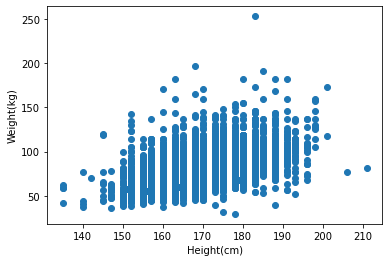

In [5]:
plt.scatter(heights, weights)
plt.xlabel("Height(cm)")
plt.ylabel("Weight(kg)")
plt.show()

In [6]:
# 겹치는 점이 많아서 제대로 보이지 않습니다.
# 특히나 키는 인치를 cm로 변환한 것이라서, 중간중간 빈 곳이 많습니다.
# jitter는 random noise를 주어서 점을 약간씩 옮겨주는 것입니다. 
# Uniform noise보다는 Gaussian noise가 더 좋은 효과를 줍니다. Gaussian noise를 주겠습니다. 
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

In [7]:
# 1인치는 대략 2.54cm입니다. 대략 -1.27 에서 1.27 사이의 노이즈를 주면 될 것 같습니다.
heights = Jitter(heights, 1.27)
weights = Jitter(weights, 0.5)

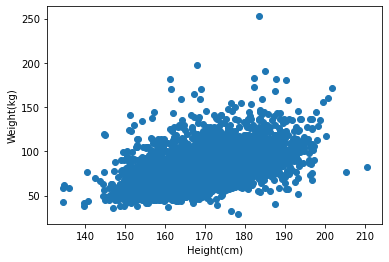

In [8]:
plt.scatter(heights, weights)
plt.xlabel("Height(cm)")
plt.ylabel("Weight(kg)")
plt.show()

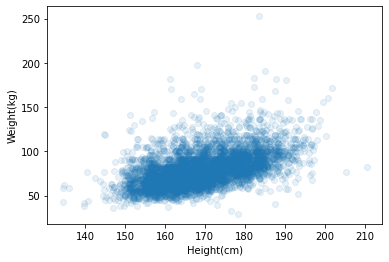

In [9]:
# 훨씬 나아졌습니다. 하지만 여전히 문제가 있습니다. 
# 겹치는 점이 많아서 실제로 얼마나 상관관계가 있는지가 보이지를 않습니다. 
# 이를 해결하는 좋은 방법은 점을 투명하게 만들어주는 것입니다.
# 아래처럼 alpha channel을 이용하면 됩니다.
plt.scatter(heights, weights, alpha=0.1)
plt.xlabel("Height(cm)")
plt.ylabel("Weight(kg)")
plt.show()

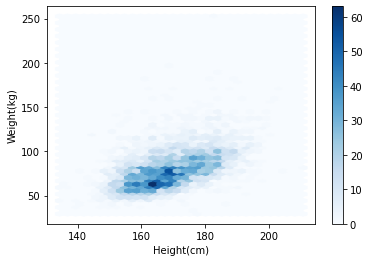

In [10]:
# 훨씬 보기 좋고, 잘 보입니다. 
# 하지만 이 경우에도 여전히 "정확한 점의 밀도"를 보기는 쉽지 않습니다.
# 이를 위해 pyplot에는 hexbin이라는 방식을 지원합니다.

plt.hexbin(heights, weights, gridsize=(30, 30), cmap="Blues")
plt.xlabel("Height(cm)")
plt.ylabel("Weight(kg)")
plt.colorbar()
plt.show()

In [11]:
# Sample이 아니라 전체를 하려면 조금 더 고민해야 합니다.
heights, weights = df.htm3, df.wtkg2
heights = Jitter(heights, 1.27)
weights = Jitter(weights, 0.5)

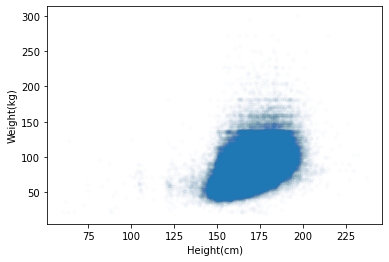

In [12]:
# Scatter는 조금 까다롭습니다.
plt.scatter(heights, weights, alpha=0.01, s=10)
plt.xlabel("Height(cm)")
plt.ylabel("Weight(kg)")
plt.show()

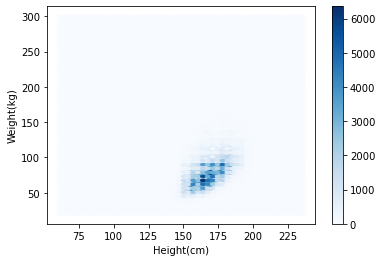

In [13]:
# Hexbin은 그럭저럭 잘 작동합니다.
heights, weights = df.htm3, df.wtkg2
plt.hexbin(heights, weights, gridsize=(50, 50), cmap="Blues")
plt.xlabel("Height(cm)")
plt.ylabel("Weight(kg)")
plt.colorbar()
plt.show()

## Plotting Percentiles

때때로는 Dataset을 그룹으로 나누어서 그 차이를 보는 것이 경향성을 더 명확하게 보여주기도 합니다. 
한 데이터를 group으로 나누고, 다른 데이터의 분포를 그려봅시다.

In [14]:
# 데이터프레임에서 데이터가 없는 row를 지웁니다. 
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

In [15]:
# 키를 여러개의 그룹으로 나누어봅시다. 
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins) # cleaned의 키를 기준으로 그룹을 나누어 인덱스를 구합니다 
groups = cleaned.groupby(indices) # 구한 인덱스를 통해서 group으로 나누어진 Groupby object를 만듭니다.

In [16]:
# pandas의 Groupby object는 iterabale입니다. 즉, for loop등에서 iteration을 위해서 사용 가능합니다.
# 각 그룹의 크기를 구해봅시다.
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


In [17]:
# 지난주 코드에서 cdf와 pdf그리는 코드를 다시 가져왔습니다.
def values2cdf(values):
    sorted_values = sorted(values)
    total = len(values)
    x = []
    y = []
    for i, value in enumerate(sorted_values):
        x.append(value)
        y.append(i/total)
    return x, y

def values2pdf(values, bins=10):
    import numpy as np
    tot = len(values)   
    hist, bins = np.histogram(values, bins=bins) 
    xval = bins[:-1] + 0.5 * (bins[1:] - bins[:-1]) # 두 bin 사이의 점을 고릅니다
    binsizes = (bins[1:] - bins[:-1]) # binsize가 uniform이 아니더라도 쓸 수 있도록
    pdf = hist / (tot * binsizes)
    return xval, pdf

def getPercentileValueFromCDF(cdf, percentile):
    cdf[percentile*len(cdf)//100]
    return cdf[percentile*len(cdf)//100]

In [18]:
# 각 그룹의 평균 키와 cdf를 구해봅시다.
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [values2cdf(group.wtkg2)[0] for i, group in groups]

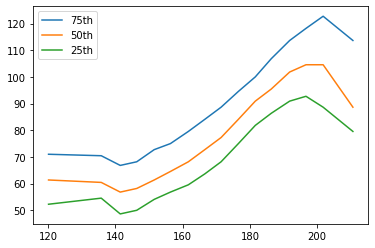

In [19]:
for percent in [75, 50, 25]:
    weight_percentiles = [getPercentileValueFromCDF(cdf, percent) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(mean_heights, weight_percentiles, label=label)
plt.legend()

In [20]:
# 또 다른 방법은 키를 여러 그룹으로 나누어서 각각의 pdf를 그려보는 것입니다. 
bins = np.arange(135, 215, 20)
indices = np.digitize(cleaned.htm3, bins) # cleaned의 키를 기준으로 그룹을 나누어 인덱스를 구합니다 
groups = cleaned.groupby(indices) # 구한 인덱스를 통해서 group으로 나누어진 Groupby object를 만듭니다.
mean_heights = [group.htm3.mean() for i, group in groups]
xs = [values2pdf(group.wtkg2)[0] for i, group in groups]
pdfs = [values2pdf(group.wtkg2)[1] for i, group in groups]

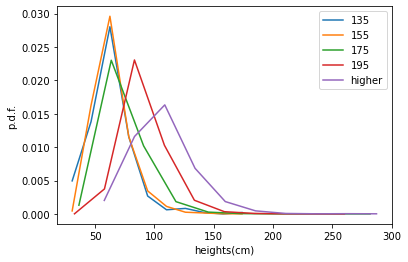

In [21]:
bins = np.append(bins, "higher")
for i, pdf in enumerate(pdfs):
    plt.plot(xs[i], pdf, label=bins[i])
plt.legend()
plt.xlabel("heights(cm)")
plt.ylabel("p.d.f.")
plt.show()

## Pearson correlation

In [22]:
# numpy의 dot function을 통해서 pearson correlation을 구해봅시다. 먼저 covariance부터 구합니다.
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [23]:
# 실제로 테스트해 봅시다.
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.33290857697772

In [24]:
# Correlation은 covariance와 standard deviation들의 곱으로 정의됩니다.
def PearsonCorr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    stdx = np.std(xs)
    stdy = np.std(ys)
    
    corr = Cov(xs, ys) / (stdx * stdy)
    return corr

In [25]:
PearsonCorr(heights, weights)

0.5087364789734591

In [26]:
# Numpy의 corrcoef는 pearson correlation을 구해줍니다.
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

In [27]:
# Matrix 형태가 나오는 이유는, 두 변수 a, b가 주어졌을 때 아래와 같은 값을 계산해주기 때문입니다.
# Corr(a, a), Corr(a, b)
# Corr(b, a), Corr(b, b)
# scipy의 stats에도 pearson correlation을 구해주는 함수가 있습니다.
stats.pearsonr(heights, weights)

(0.5087364789734597, 0.0)

In [28]:
# 뒤의 값은 2-tailed p-value를 의미합니다. 추후에 가설 검정등에서 배울 것입니다.
# Pearson correlation은 비선형 관계를 작게 평가하는 경향이 있습니다.
x = np.arange(1, 100)
y = np.exp(x)

In [29]:
# 그냥 값의 Pearson Correlation은 작게 나옵니다.
print(stats.pearsonr(x, y))
# 하지만, y값에 log를 취한 값과의 Pearson correlation은 1이 나옵니다.
# 즉, Pearson correlation이 못보는 비선형 관계에서의 correlation은 더 높을 수도 있다는 것입니다.
print(stats.pearsonr(x, np.log(y)))

(0.2532736844999744, 0.011425065668901434)
(1.0, 0.0)


In [30]:
# Rank Correlation은 위의 문제를 해결할 수 있습니다.
# 구현이 단순한 Spearman correlation을 먼저 구현해봅시다.
def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return PearsonCorr(xranks, yranks)

In [31]:
# 아까의 x와 exp(x)에 대해서 구해봅시다. 거의 1이 나옵니다.
x = np.arange(1, 100)
y = np.exp(x)
SpearmanCorr(x, y) 

0.9999999999999999

In [32]:
# scipy.stats의 spearmanr을 사용해도 됩니다.
stats.spearmanr(x, y)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [33]:
# 아까의 키와 몸무게의 예로 돌아가 봅시다.
stats.spearmanr(heights, weights)

SpearmanrResult(correlation=0.5405846262320476, pvalue=0.0)

In [34]:
# Spearman correlation이 pearson correlation보다 더 큽니다.
# 지난 강의에서 성인의 몸무게는 lognormal distribution을 따른다고 말씀드렸습니다.
# 혹시 몸무게에 log를 취하면 더 잘 맞을까요?
stats.pearsonr(heights, np.log(weights))

(0.531728260598347, 0.0)

In [35]:
# Spearman 이외에도 kendall-tau라는 rank correlatin을 재는 방식이 존재합니다.
def KendallTauCorr(xs, ys):
    xs = list(xs)
    ys = list(ys)
    sorted_pairs = sorted(zip(xs, ys))
    discord = 0
    n = len(sorted_pairs)
    for i in range(n-1):
        target_y = sorted_pairs[i][1]
        for j in range(i+1, n):
            if(sorted_pairs[j][1] < target_y):
                discord += 1
    cord = n * (n - 1) / 2 - discord
    return (cord - discord) / (cord + discord)
# 문제는 엄청 느립니다 -_-

In [36]:
sample = SampleRows(df, 5000)
sample = sample.dropna(subset=["htm3", "wtkg2"])
heights2, weights2 = sample.htm3, sample.wtkg2
KendallTauCorr(heights2, weights2)

0.47395291849915255

In [37]:
# stats.kendalltau를 쓰셔도 됩니다. 위와 값이 다른 이유는 tie를 다루는 방법 때문입니다.
stats.kendalltau(heights2, weights2)

KendalltauResult(correlation=0.4029374416609402, pvalue=0.0)

# Exercises
NSFG데이터로 어머니의 나이와 자식의 무게에 대한 scatter plot을 그려봅시다. percentile도 그려보고, correlations들도 그려봅시다. 이 관계에 대해서 어떤 결론을 내릴 수 있나요?

In [38]:
preg = pd.read_csv("./2002FemPreg.tsv", sep = "\t")
live = preg[preg.outcome == 1]
#firsts = live[live.birthord == 1]
#others = live[live.birthord != 1]
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [39]:
# Solution goes here
# scatter plot을 먼저 그려봅시다.

In [40]:
# Solution goes here
# hexbin plot도 그려봅시다.

In [41]:
# 임신시의 나이를 여러개의 그룹으로 나누어봅시다. 
# percentile마다 값을 그려봅니다.

In [42]:
# pdf를 그려봅시다.

In [43]:
# Correlation을 구해봅시다